<a href="https://colab.research.google.com/github/Lolillosky/PHD_Code/blob/main/Market_Risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.utils import shuffle  
from tensorflow.python.ops.numpy_ops import np_config
from itertools import product
np_config.enable_numpy_behavior()
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
from scipy.stats import ks_2samp 


from IPython.display import clear_output

from numpy.linalg import cholesky

In [ ]:
!wget "https://www.1001fonts.com/download/latin-modern-roman.zip"
!mkdir Font
!unzip latin-modern-roman.zip -d Font

import matplotlib.font_manager as fm
import matplotlib

# fetch the name of font that was installed
path = "Font"
fontprop = fm.FontProperties(fname=path)

matplotlib.rcParams['font.family'] = fontprop.get_family()

clear_output()

In [ ]:
!rm -r {'PHD_Code'}
!git clone https://github.com/Lolillosky/PHD_Code.git

import sys
sys.modules.pop
sys.path.insert(0,'PHD_Code')

clear_output()

In [ ]:
tf.keras.backend.set_floatx('float64')



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
PATH_DATA = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_new/DATA/"
PATH_FIGS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_new/FIGS/"
PATH_MODELS = "/content/drive/MyDrive/PHD/Work PHD/CODE/market_risk_new/MODELS/"


In [ ]:
import Option_formulas
# Option_formulas.BlackTF(1.0,1.0,1.0,0,0.2,True)
import Miscellanea
import Deep_learning_models

In [ ]:
Option_formulas.BlackTF(1.0,1.0,1.0,0,0.2,True)

<tf.Tensor: shape=(), dtype=float32, numpy=0.07965565>

In [ ]:
hist_data = pd.read_excel(PATH_DATA + 'Hist_data.xlsx', index_col='Dates')

display(hist_data.head(3))
display(hist_data.tail(3))


,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2010-01-01,7.526,37.458,125.0310,23.275,41.67,35.088
2010-01-04,7.643,37.428,126.5115,23.198,42.85,34.045
2010-01-05,7.656,38.004,124.9832,23.318,43.68,33.323


,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2022-12-06,142.91,34.215,147.50,24.998,131.59,29.305
2022-12-07,140.94,34.771,147.27,25.134,131.50,29.658
2022-12-08,140.94,34.771,147.27,25.134,131.50,29.658


In [ ]:
risk_horizon = 10
hist_data_length = 250

hist_schocks = pd.DataFrame(data = np.log(hist_data.iloc[risk_horizon:].values/ hist_data.iloc[0:-risk_horizon].values),
                            index =  hist_data.index[risk_horizon:], columns = hist_data.columns) 

hist_schocks = hist_schocks.iloc[-hist_data_length:]

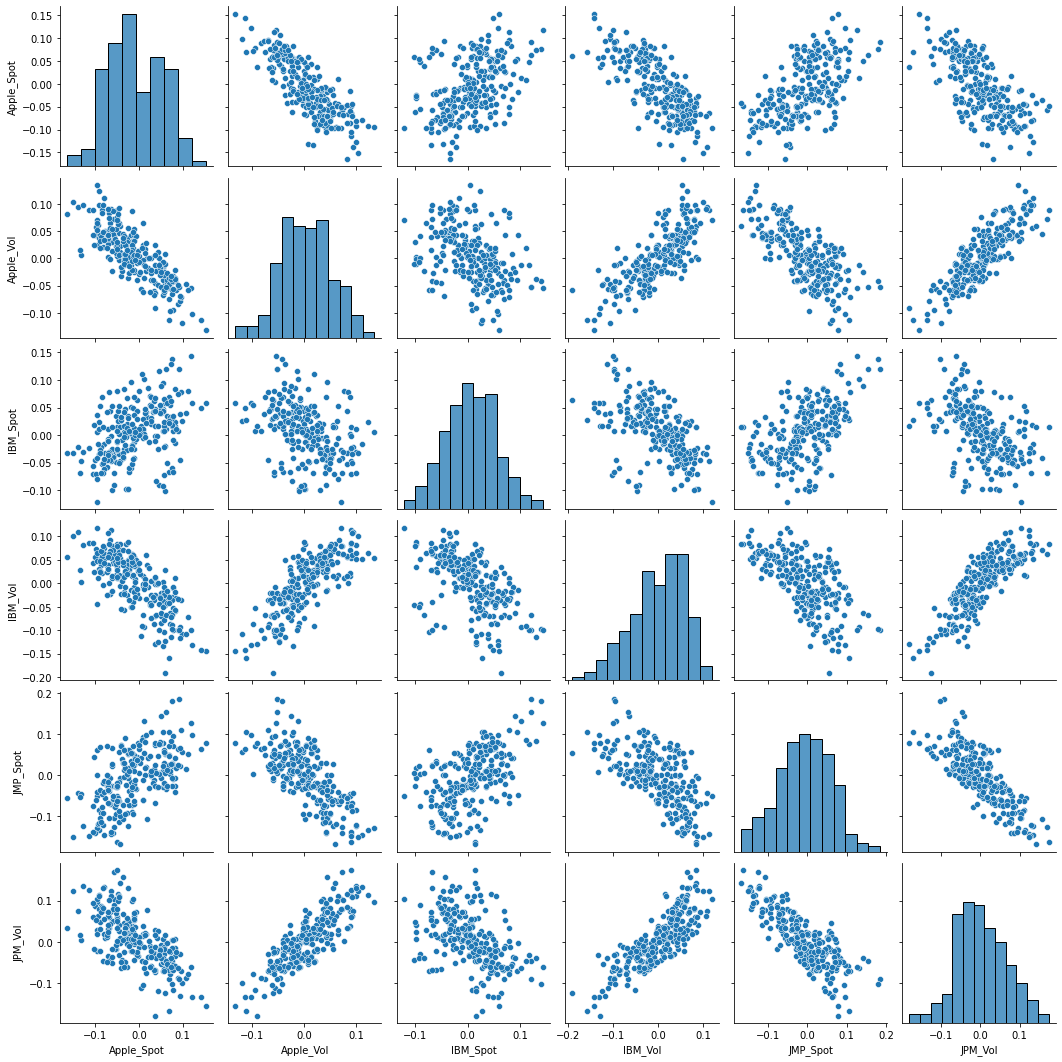

In [ ]:
sns.pairplot(hist_schocks);

plt.savefig(PATH_FIGS + 'histdata.pdf')

In [ ]:
from sklearn.mixture import GaussianMixture

GM = GaussianMixture(n_components= 6, random_state=1234)

GM.fit(hist_schocks)

NameError: ignored

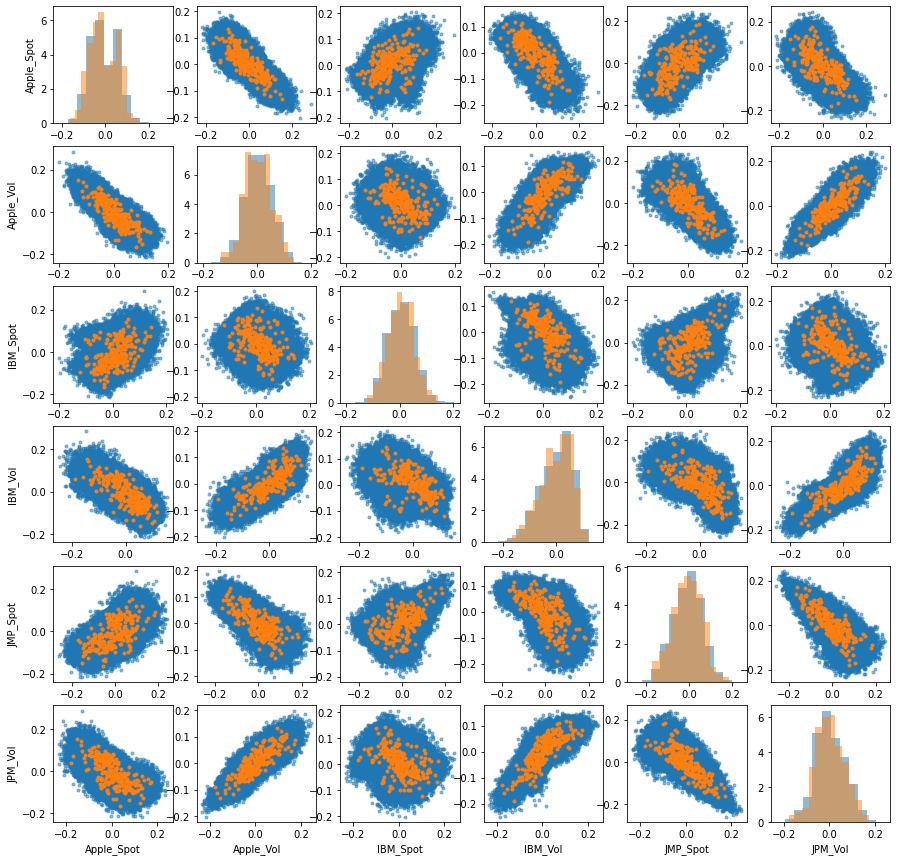

In [ ]:
num_sims = 140000

np.random.seed(5678)

sim_schocks = shuffle(GM.sample(num_sims)[0])

Miscellanea.plot_schocks(6,sim_schocks,hist_schocks,hist_schocks.columns,12)     


In [ ]:
TTM = 3.0
rfr = 0.01  

S_A_0, S_B_0, S_C_0 = 1.0, 1.0, 1.0

vol_A, vol_B, vol_C  = 0.2, 0.3, 0.15

K_A, K_B, K_C = 1.0, 1.0, 1.0

K = 1.0

correlations = [[1.0, 0.6, 0.4],[0.6,1.0,0.7],[0.4,0.7,1.0]]

base_scenario = np.array([S_A_0, vol_A, S_B_0, vol_B, S_C_0, vol_C])

sim_scenarios = tf.constant(base_scenario * np.exp(sim_schocks))

hist_var_scenarios = base_scenario * np.exp(hist_schocks)

chol = cholesky(correlations)

brow_ind =  np.sqrt(TTM) * np.random.normal(loc = 0.0, scale = 1.0, size = (num_sims, 3))

brow_correl = np.matmul(brow_ind, chol.T)


with tf.GradientTape() as tape:

  tape.watch(sim_scenarios)

  Spots_T = sim_scenarios[:,[0,2,4]]*tf.exp((rfr - 0.5 * sim_scenarios[:,[1,3,5]]**2)*TTM + sim_scenarios[:,[1,3,5]]* brow_correl)
  strikes = [K_A, K_B, K_C]
  payoff = tf.maximum(tf.exp(tf.reduce_mean(tf.math.log(Spots_T/strikes), axis = 1))-K,0)*tf.exp(-rfr * TTM)

  
sens = tape.gradient(payoff, sim_scenarios)



In [ ]:

# Miscellanea.delete_content_of_folder(PATH_MODELS)

# alphas = [0, 0.1, 0.5, 1.0, 10.0]
# cells_layer = [32, 64, 128]
# num_hidden_layer = [1, 2, 4, 6]


# for a, c, n in product(alphas, cells_layer, num_hidden_layer):

#   tf.keras.utils.set_random_seed(9876)
   
#   print('FITTING MODEL: alpha: {0}, cells: {1}, num_hidden: {2}'.format(a, c, n))

#   path = PATH_MODELS + 'alpha' + '_' + str(a) + '_cells_' + str(c) + '_hidden_' + str(n) + '/'
#   os.mkdir(path)

#   dense_model = Deep_learning_models.build_dense_model(sim_scenarios.shape[1],n,c,'relu','linear')

#   model = Deep_learning_models.Diff_learning_scaler(Deep_learning_models.DiffLearning(dense_model), alpha = a)


#   model.fit(sim_scenarios.numpy()[0:100000], payoff.numpy()[0:100000], sens.numpy()[0:100000], batch_size= 32, epochs= 20)

#   clear_output()

#   model.save(path)


In [ ]:
a = 1.0
n = 4
c = 128

tf.random.set_seed(9876)
dense_model = Deep_learning_models.build_dense_model(sim_scenarios.shape[1],n,c,'relu','linear')
model = Deep_learning_models.Diff_learning_scaler(Deep_learning_models.DiffLearning(dense_model), alpha = a)
model.fit(sim_scenarios.numpy()[0:100000], payoff.numpy()[0:100000], sens.numpy()[0:100000], batch_size= 32, epochs= 20)

NameError: ignored

In [ ]:
closed_form = Option_formulas.BasketOptionVectorized(3, sim_scenarios[:,[0,2,4]].numpy(), [K_A, K_B, K_C],
                  K,
                  np.array([rfr, rfr, rfr]), rfr, [0.0, 0.0, 0.0], 
                  sim_scenarios[:,[1,3,5]].numpy(), np.array(correlations),
                  TTM, True) 

In [ ]:
import time

alphas = [0, 0.1, 0.5, 1.0, 10.0]
cells_layer = [32, 64, 128]
num_hidden_layer = [1, 2, 4, 6]

models = {}

train_range = range(0,100000)
cv_range = range(100000,120000)
test_range = range(120000,140000)

for a, c, n in product(alphas, cells_layer, num_hidden_layer):

  model_name = 'alpha' + '_' + str(a) + '_cells_' + str(c) + '_hidden_' + str(n) 
  
  print(model_name)

  path = PATH_MODELS +  model_name + '/'

  model = Deep_learning_models.Diff_learning_scaler.open(path)

  y_pred_train = model.predict(sim_scenarios.numpy()[train_range], batch_size = len(train_range))['y']
  mse_train = mean_squared_error(y_pred_train, payoff.numpy()[train_range])

  y_pred_cv = model.predict(sim_scenarios.numpy()[cv_range], batch_size = len(cv_range))['y']
  mse_cv = mean_squared_error(y_pred_cv, payoff.numpy()[cv_range])

  y_pred_test = model.predict(sim_scenarios.numpy()[test_range], batch_size = len(test_range))['y']
  mse_test = mean_squared_error(y_pred_test, payoff.numpy()[test_range])

  spearman_train = spearmanr(y_pred_train, closed_form[train_range])
  ks_train = ks_2samp(y_pred_train, closed_form[train_range])

  spearman_cv = spearmanr(y_pred_cv, closed_form[cv_range])
  ks_cv = ks_2samp(y_pred_cv, closed_form[cv_range])

  spearman_test = spearmanr(y_pred_test, closed_form[test_range])
  ks_test = ks_2samp(y_pred_test, closed_form[test_range])

  results_dict = {}
  results_dict['model_name'] = model_name

  results_dict['model_params'] = {'alpha': a, 'cells': c, 'hidden': n}

  results_dict['model'] = model
  
  results_dict['mse_train'] = mse_train
  results_dict['mse_cv'] = mse_cv
  results_dict['mse_test'] = mse_test
  
  results_dict['spearman_train'] = spearman_train
  results_dict['spearman_cv'] = spearman_cv
  results_dict['spearman_test'] = spearman_test
  
  results_dict['ks_train'] = ks_train
  results_dict['ks_cv'] = ks_cv
  results_dict['ks_test'] = ks_test
  
  
  models[(a,n,c)] = results_dict

  # time.sleep(3)

  clear_output()


In [ ]:
mse_list = []
mse_keys = []

for key in models:

  mse_keys += [key]
  mse_list += [models[key]['mse_cv']]


print('Best model:')

models[mse_keys[np.argmin(mse_list)]]

Best model:


{'model_name': 'alpha_10.0_cells_32_hidden_6',
 'model_params': {'alpha': 10.0, 'cells': 32, 'hidden': 6},
 'model': <Deep_learning_models.Diff_learning_scaler at 0x7f1f05367f40>,
 'mse_train': 0.051155552639037406,
 'mse_cv': 0.048345555549560416,
 'mse_test': 0.050063608557698376,
 'spearman_train': SpearmanrResult(correlation=0.9999168840307878, pvalue=0.0),
 'spearman_cv': SpearmanrResult(correlation=0.9999150543232874, pvalue=0.0),
 'spearman_test': SpearmanrResult(correlation=0.9999156030577888, pvalue=0.0),
 'ks_train': KstestResult(statistic=0.07023000000000001, pvalue=6.937399245869732e-215),
 'ks_cv': KstestResult(statistic=0.06845000000000001, pvalue=3.489153644087334e-41),
 'ks_test': KstestResult(statistic=0.06970000000000004, pvalue=1.0945919140014584e-42)}

In [ ]:
bayes_error_train = mean_squared_error(closed_form[train_range], payoff.numpy()[train_range])
bayes_error_cv = mean_squared_error(closed_form[cv_range], payoff.numpy()[cv_range])
bayes_error_test = mean_squared_error(closed_form[test_range], payoff.numpy()[test_range])

print(bayes_error_train, bayes_error_cv, bayes_error_test)


0.05114472045262213 0.04835375704760562 0.05004821715091719


In [ ]:
np.std((closed_form[train_range].numpy()-payoff.numpy()[train_range])**2)/np.sqrt(20000)

0.0011765665240219961

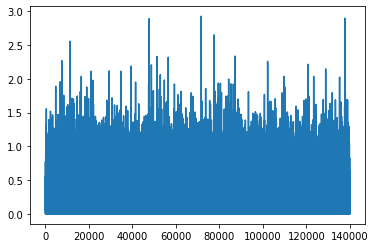

In [ ]:
plt.plot(payoff)

In [ ]:
plot_results = {}


for c, n in product(cells_layer, num_hidden_layer):

  plot_results[(c,n)] = {}

  plot_results[(c,n)]['name'] = '{0} hidden layers, {1} cells'.format(n,c)

  plot_results[(c,n)]['name']

  plot_results[(c,n)]['mse_train'] = np.zeros(len(alphas))
  plot_results[(c,n)]['mse_cv'] = np.zeros(len(alphas))
  plot_results[(c,n)]['mse_test'] = np.zeros(len(alphas))
  plot_results[(c,n)]['spearman_train'] = np.zeros(len(alphas))
  plot_results[(c,n)]['spearman_cv'] = np.zeros(len(alphas))
  plot_results[(c,n)]['spearman_test'] = np.zeros(len(alphas))
  plot_results[(c,n)]['ks_train'] = np.zeros(len(alphas))
  plot_results[(c,n)]['ks_cv'] = np.zeros(len(alphas))
  plot_results[(c,n)]['ks_test'] = np.zeros(len(alphas))
  

for m in models:

  a = models[m]['model_params']['alpha'] 
  n = models[m]['model_params']['hidden']
  c = models[m]['model_params']['cells']

  plot_results[(c,n)]['mse_train'][alphas.index(a)] = models[m]['mse_train']
  plot_results[(c,n)]['mse_cv'][alphas.index(a)] = models[m]['mse_cv']
  plot_results[(c,n)]['mse_test'][alphas.index(a)] = models[m]['mse_test']

  plot_results[(c,n)]['spearman_train'][alphas.index(a)] = models[m]['spearman_train'].correlation
  plot_results[(c,n)]['spearman_cv'][alphas.index(a)] = models[m]['spearman_cv'].correlation
  plot_results[(c,n)]['spearman_test'][alphas.index(a)] = models[m]['spearman_test'].correlation

  plot_results[(c,n)]['ks_train'][alphas.index(a)] = models[m]['ks_train'].statistic
  plot_results[(c,n)]['ks_cv'][alphas.index(a)] = models[m]['ks_cv'].statistic
  plot_results[(c,n)]['ks_test'][alphas.index(a)] = models[m]['ks_test'].statistic
  
  

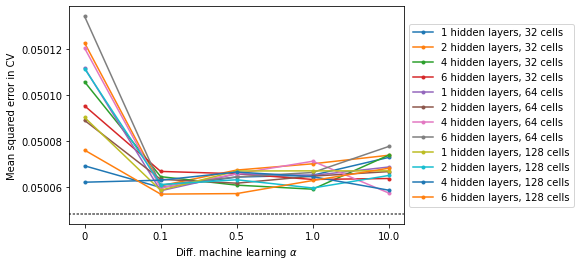

In [ ]:
for p in plot_results:

  # print(p)
  plt.plot(plot_results[p]['mse_test'], '.-', label = plot_results[p]['name'])
  plt.axhline(y = bayes_error_test, color = 'grey', linestyle = ':')
  
  
plt.xticks(ticks = range(len(alphas)),labels = alphas)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'Diff. machine learning $\alpha$')
plt.ylabel('Mean squared error in CV');

plt.gcf().set_size_inches(6,4)  

plt.savefig(PATH_FIGS + 'MSE_CV.pdf',bbox_inches ='tight')

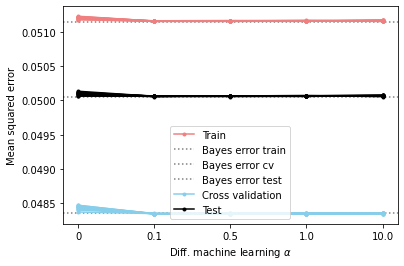

In [ ]:

for i,p in enumerate(plot_results):

  if i == 0:
    plt.plot(plot_results[p]['mse_train'], '.-', color = 'lightcoral', label='Train')
    plt.axhline(y = bayes_error_train, color = 'grey', linestyle = ':', label='Bayes error train')
    plt.axhline(y = bayes_error_cv, color = 'grey', linestyle = ':', label='Bayes error cv')
    plt.axhline(y = bayes_error_test, color = 'grey', linestyle = ':', label='Bayes error test')
    plt.plot(plot_results[p]['mse_cv'], '.-', color = 'skyblue', label='Cross validation')
    plt.plot(plot_results[p]['mse_test'], '.-', color = 'black', label='Test')
    
  else:
    plt.plot(plot_results[p]['mse_train'], '.-', color = 'lightcoral')
    plt.plot(plot_results[p]['mse_cv'], '.-', color = 'skyblue')
    plt.plot(plot_results[p]['mse_test'], '.-', color = 'black')
    

  
plt.xticks(ticks = range(len(alphas)),labels = alphas)
plt.legend()
plt.xlabel(r'Diff. machine learning $\alpha$')
plt.ylabel('Mean squared error')

plt.savefig(PATH_FIGS + 'train_test_mse.pdf',bbox_inches ='tight');

In [ ]:
xxx = models[(0.1,6,32)]['model']

In [ ]:
xxx.diff_learning_model.model.layers[6].activation

<function keras.activations.linear(x)>

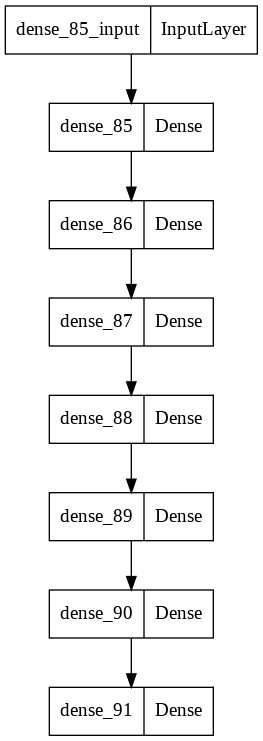

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(xxx.diff_learning_model.model)

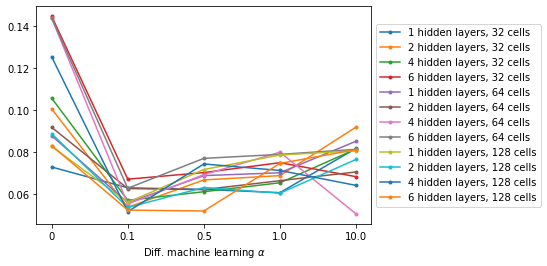

In [ ]:
for p in plot_results:

  # print(p)
  # plt.plot(plot_results[p]['ks_train'], '.-', label = plot_results[p]['name'])
  plt.plot(plot_results[p]['ks_cv'], '.-', label = plot_results[p]['name'])
  
  # plt.axhline(y = bayes_error, color = 'grey', linestyle = ':')
  
plt.xticks(ticks = range(len(alphas)),labels = alphas)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'Diff. machine learning $\alpha$');

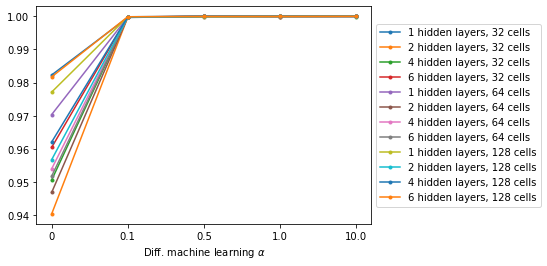

In [ ]:
for p in plot_results:

  # print(p)
  # plt.plot(plot_results[p]['ks_train'], '.-', label = plot_results[p]['name'])
  plt.plot(plot_results[p]['spearman_cv'], '.-', label = plot_results[p]['name'])
  
  # plt.axhline(y = bayes_error, color = 'grey', linestyle = ':')
  
plt.xticks(ticks = range(len(alphas)),labels = alphas)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel(r'Diff. machine learning $\alpha$');   

In [ ]:
hist_schocks.head()


,Apple_Spot,Apple_Vol,IBM_Spot,IBM_Vol,JMP_Spot,JPM_Vol
Dates,,,,,,
2021-12-24,-0.017823,-0.005603,0.051362,-0.049606,-0.016148,-0.000310
2021-12-27,0.025783,-0.023807,0.071155,-0.045324,0.001519,-0.009170
2021-12-28,0.028055,-0.039837,0.069219,-0.041905,-0.003084,-0.015767
2021-12-29,0.000446,-0.028442,0.079899,-0.032101,0.003918,-0.013509
2021-12-30,0.033902,-0.060599,0.061442,-0.035395,-0.012105,-0.026903
